<a href="https://colab.research.google.com/github/Udendra103/Healthcare-Diabetes-Prediction-/blob/master/uden_cnn_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

histopathologic_cancer_detection_path = kagglehub.competition_download('histopathologic-cancer-detection')

print('Data source import complete.')


SUMMARY OF THE PROJECT


Objective

Develop a deep learning model to classify 96x96 histopathological images as cancerous or non-cancerous, leveraging the Histopathologic Cancer Detection dataset. The goal is to assist doctors by automating metastases detection, enhancing diagnostic efficiency.

Problem Statement

Type of Problem: Binary classification of images (96x96 resolution).
Task: Identify the presence of metastases in histopathology images, even if the metastases are as small as single cells.
Evaluation Metric: Area under the ROC curve (AUC-ROC).

Dataset Details
Size:
Training: ~220k images.
Evaluation: ~57k images.
Origin:
Subset of the PCam dataset, derived from the Camelyon16 Challenge dataset.
10x undersampling applied for broader field of view (pixel resolution of 2.43 microns).
File Structure:
Each image has a unique ID as its filename.
train_labels.csv contains ground truth labels for training images.
Labels for test images need to be predicted.
Labeling:
Positive: The center 32x32px region contains at least one pixel of tumor tissue.
Negative: Tumor tissue in the outer region does not influence the label but is included for supporting fully-convolutional models.

Data Cleaning

The dataset does not show any missing values or anomalies in the initial inspection, so no major data cleaning is required at this stage. However, for the image data:

Image Normalization and Augmentation: Preprocessing techniques such as normalization, resizing, and data augmentation (rotation, flipping, etc.) will be beneficial for improving the model's performance and generalization.

Key Challenges
Microscopic Scale: Metastases may appear as small as single cells.
Data Characteristics:
Negative images may still contain metastases outside the center region.
Cropping images to the center region (32x32px) could improve model focus and accuracy.
Outer Region Usage:
Provided to facilitate fully-convolutional models without zero-padding, ensuring consistent behavior when applied to whole-slide images.


Model Architecture

The architecture for this project progressively evolved from a basic convolutional neural network (CNN) to a state-of-the-art EfficientNetB0 model, leveraging transfer learning to maximize performance.

1. Baseline Model Architecture
The initial architecture was a simple CNN designed to establish baseline performance. Its key components were:

Convolutional Layers: Extract spatial features from the input images.
Max-Pooling Layers: Downsample feature maps, reducing computational complexity and preventing overfitting.
Fully Connected Layers: Combine extracted features to classify images into metastatic or non-metastatic categories.
Dropout Layers: Introduced to mitigate overfitting by randomly dropping units during training.
Output Layer: A single neuron with a sigmoid activation function for binary classification.
While the baseline CNN provided reasonable results, it showed signs of overfitting and was limited in its capacity to generalize to complex image features.

2. EfficientNetB0 Architecture
To address the limitations of the baseline model, we adopted EfficientNetB0, a SOTA architecture pre-trained on ImageNet. EfficientNet is known for its:

Compound Scaling: Balances model depth, width, and resolution to optimize both accuracy and efficiency.
Lightweight Design: Achieves SOTA performance while remaining computationally efficient.
Key Features of the EfficientNetB0 Model:

Pretrained Backbone: The EfficientNetB0 backbone was frozen initially to utilize its feature extraction capabilities from pretraining on large-scale datasets.
Custom Classifier: A fully connected classifier was added on top of the backbone:
A Global Average Pooling (GAP) Layer to aggregate spatial information from feature maps.
Dense Layers: Fully connected layers with ReLU activation to learn task-specific patterns.
Dropout Layer: Added for regularization to reduce overfitting.
Output Layer: A single neuron with sigmoid activation for binary classification.

3. Transfer Learning and Fine-Tuning
EfficientNetB0 was leveraged in two phases:

Transfer Learning: The pretrained backbone was frozen, and only the custom classifier layers were trained. This ensured that the pre-trained weights were not overwritten while the model adapted to the specific dataset.
Fine-Tuning: The top layers of the backbone were unfrozen and retrained with a lower learning rate to further adapt the pre-trained weights to the histopathologic cancer dataset.

4. Why EfficientNetB0?
Feature Efficiency: EfficientNetB0 captures both low-level and high-level features efficiently due to its compound scaling approach.
Transfer Learning Advantage: Pretrained weights accelerate convergence and improve generalization on small or medium-sized datasets like the one used in this project.
Scalability: It offers a balance between computational cost and performance, making it suitable for both experimentation and deployment.


Significance

This project demonstrates the potential of deep learning models, such as EfficientNet, to enhance cancer diagnostics by automating metastases detection. It highlights the importance of transfer learning, regularization techniques, and data preprocessing in achieving high accuracy and reducing overfitting. With further refinements, this model could significantly contribute to medical image analysis and diagnostic efficiency.


In [ ]:
# Import libraries

# General libraries
import numpy as np
import pandas as pd
import os
import random
from sklearn.utils import shuffle
import shutil

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches
import json
from PIL import Image
import pathlib


# Work with images
from skimage.transform import rotate
from skimage import io
import cv2 as cv

# Model Development
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import Model


import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Exploratory Data Analysis (EDA)

In [ ]:
test_path = '../input/histopathologic-cancer-detection/test/'
train_path = '../input/histopathologic-cancer-detection/train/'
sample_submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
train_dir = pathlib.Path(train_path).with_suffix('')
test_dir = pathlib.Path(test_path).with_suffix('')

# load labels dataframe
df = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

train_imgs = list(train_dir.glob('*.tif'))
test_imgs = list(test_dir.glob('*.tif'))

In [ ]:
# declare constants for reproduciblity
RANDOM_STATE = 101
# have a look at the format of the data
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [ ]:
# take a look at the data further
df.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
# check information, data types, and for missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


Data Visualization and Preprocessing Summary
Data Visualization:

A histogram and pie chart reveal that:
59.5% of images are labeled as non-cancerous (label 0).
40.5% are labeled as cancerous (label 1).
This distribution differs from the expected 50/50 split described in the competition details, indicating a slight imbalance (40/60) but not severe compared to larger imbalances (e.g., 30/70 or 10/90).
Data Balance and Model Feasibility:

Given the slight imbalance and the large number of images, we can reasonably expect to develop a robust model capable of identifying cancerous images accurately, despite the modest imbalance.
Next Steps:

Data Cleaning and Preprocessing to prepare the images for training and ensure consistent quality and labeling before model training.
This analysis sets up a strong foundation for developing a high-performing model for cancer detection.

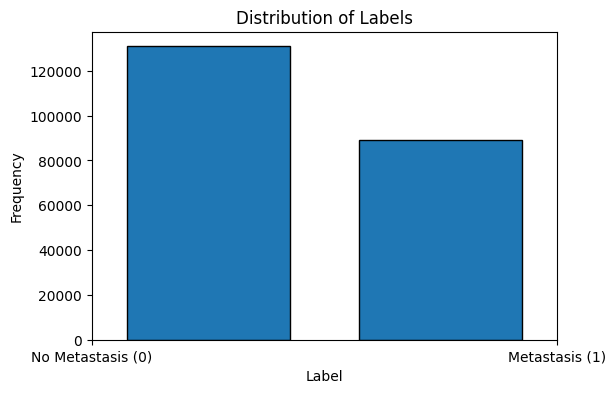

In [ ]:
# Visualizing the distribution of labels
plt.figure(figsize=(6, 4))
plt.hist(df['label'], bins=2, edgecolor='black', rwidth=0.7)
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['No Metastasis (0)', 'Metastasis (1)'])
plt.show()

In [ ]:
#create pie chart

fig = px.pie(df,
             values = df['label'].value_counts().values,
             names = df['label'].unique())
fig.update_layout(
    title={
        'text': "Label Percentage Pie Chart",
        'y':.99,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

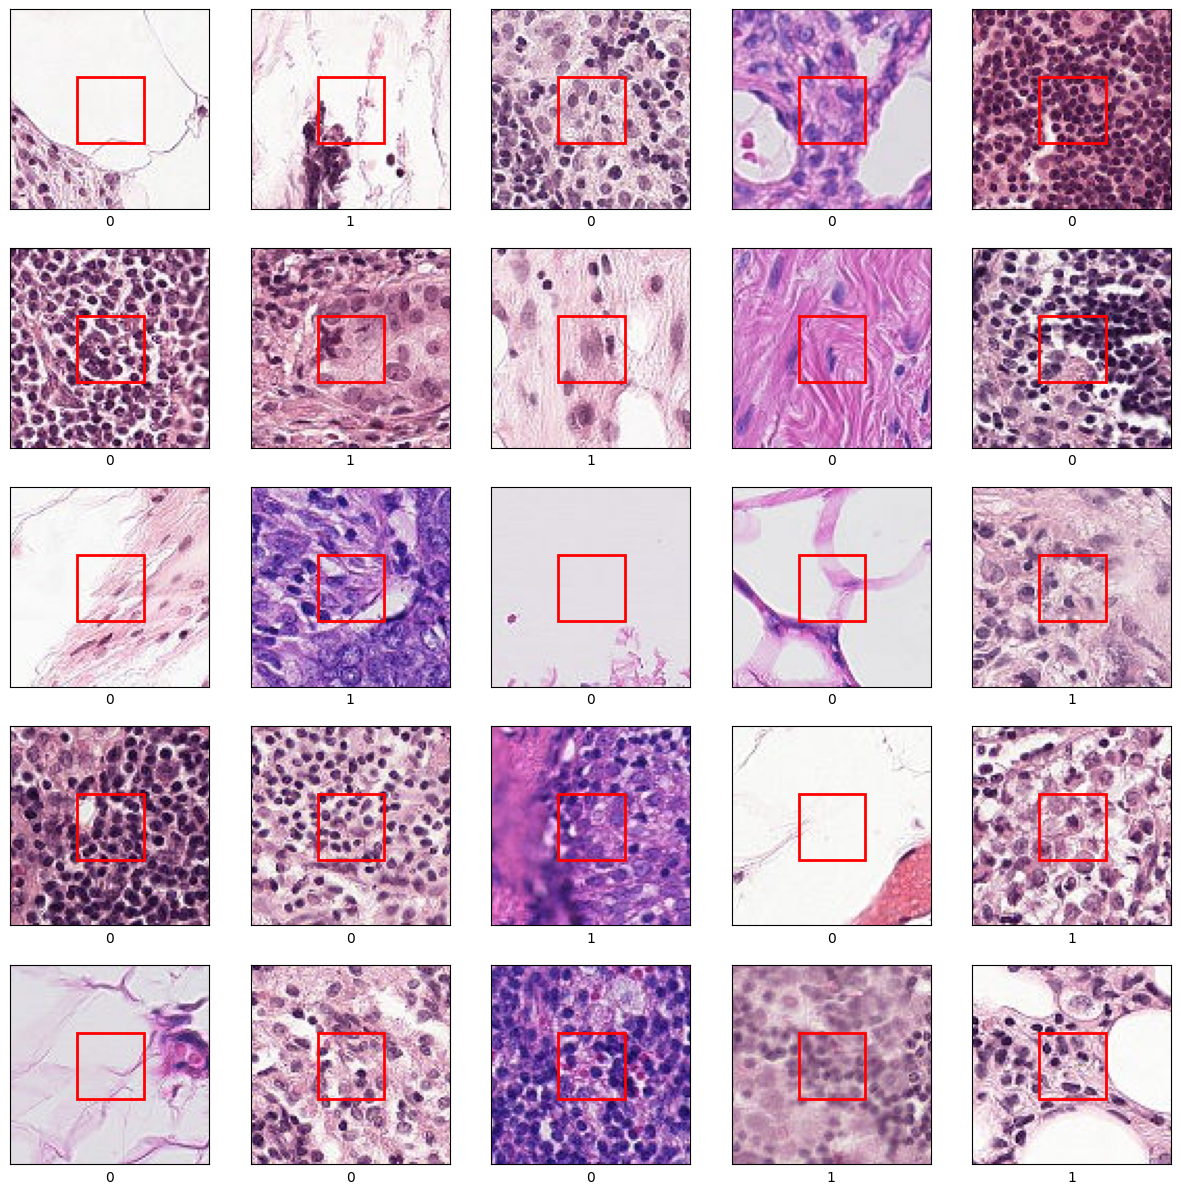

In [ ]:
# Visualize a few images

fig, ax = plt.subplots(5, 5, figsize=(15, 15))
for i, axis in enumerate(ax.flat):
    file = str(train_path + df.id[i] + '.tif')
    image = io.imread(file)
    axis.imshow(image)
    box = patches.Rectangle((32,32),32,32, linewidth=2, edgecolor='r',facecolor='none', linestyle='-')
    axis.add_patch(box)
    axis.set(xticks=[], yticks=[], xlabel = df.label[i]);

Data Preprocessing

There are a total of 220,025 images in the training folder, making it a very large dataset. To streamline the process, we'll work with a subset of the data for testing and validation.

The images are in .tif format, which is not compatible with keras.utils.image_dataset_from_directory. Thankfully, we can use ImageDataGenerator instead. To do this, we must organize the data by:

Creating new folders named after the labels.
Moving each image file into its corresponding label folder.
This approach enables ImageDataGenerator to efficiently handle the data for training and validation.

Select Train & Validation Samples
To maintain data balance, we'll randomly sample 40000 images from the dataset. Of these, 20000 will have a label of 1, while the remaining 20000 will have a label of 0.

In [ ]:
# Filter samples with the label
pos_df = df[df['label'] == 1]
neg_df = df[df['label'] == 0]

train_pos_df = pos_df.sample(n=20000, random_state=42)
train_neg_df = neg_df.sample(n=20000, random_state=42)
train_df = pd.concat([train_pos_df, train_neg_df])
# Shuffle the dataframe
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Add file type
train_df.id = train_df.id + '.tif'
train_df.label = train_df.label.astype(str)

train_df.head()

,id,label
0,49ad2195c04dc40625cb578cc233fc44deb6cca1.tif,0
1,6f70bbb436e3b6ac1b667beb2e42eab23ef54959.tif,1
2,c302a5e382e40dd3963e0202c5ae60dd096dfe3f.tif,0
3,96f01a14d4724a2b028cc68e46adce3a20f78d05.tif,1
4,bf866de062fe8ab44d89acecf3386cf7974bd863.tif,0


Data Generators

Let's setup training and validation data generators. The generators will yield batches of 32 images of size 96x96 and their labels.

We'll use the keras.preprocessing.image.ImageDataGenerator class to create generators and using the rescale parameter to normalizing the pixel values to be in the [0,1] range (from original [0, 255] range).

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tifffile as tiff

# Define batch size and image size
BATCH_SIZE = 32
IMG_SIZE = (96, 96)

TRAINING_SUBSET = "training"
VALIDATION_SUBSET = "validation"

# Create ImageDataGenerator with TIFF preprocessing
def tiff_to_rgb(img):
    # Assuming TIFF images have 3 channels (RGB)
    if img.shape[-1] != 3:
        img = tf.image.grayscale_to_rgb(img)
    return img

train_datagen = ImageDataGenerator(validation_split=0.2, preprocessing_function=tiff_to_rgb)
val_datagen = ImageDataGenerator(validation_split=0.2, preprocessing_function=tiff_to_rgb)

# Create Image Generator in batches of 32
def create_generator(datagen: ImageDataGenerator, subset: str):
    return datagen.flow_from_dataframe(
        directory = train_dir,
        dataframe = train_df,
        x_col = 'id',
        y_col = 'label',
        subset = subset,
        seed = 123,
        shuffle=True,
        target_size = IMG_SIZE,
        batch_size = BATCH_SIZE,
        class_mode = 'binary')

train_generator = create_generator(train_datagen, TRAINING_SUBSET)
val_generator = create_generator(val_datagen, VALIDATION_SUBSET)

Found 32000 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


Model

Baseline CNN Model

This CNN architecture is designed for binary image classification. The combination of convolutional layers, max-pooling, and fully connected layers enables the model to automatically extract relevant features and classify the images efficiently.

In [ ]:
# Our input feature map is 96x96x3: 96x96 stands for image height x width pixels,
# and 3 for the three color channels: R, G, and B
img_input = layers.Input(shape=IMG_SIZE + (3,))

# Standardize RGB channel values to be in the [0, 1]
x = layers.Rescaling(1./255)(img_input)

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

In [ ]:
# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 128 hidden units
x = layers.Dense(128, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully
# connected layer + sigmoid output layer
model = Model(img_input, output)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,203,489 (4.59 MB)

 Trainable params: 1,203,489 (4.59 MB)

 Non-trainable params: 0 (0.00 B)

The Output shape column shows how the size of our feature map evolves in each successive layer.
We can observe that the convolution layers reduce the size of the feature maps by a bit due to padding,
and each pooling layer halves the feature map.

Next, let's configure the sepecifications for model training. Since we're facing a binary classification problem,
we'll select the BinaryCrossentropy loss and use the RMSprop optimizer, also monitoring the classification accuracy during the training.

In [ ]:
learning_rate=0.001
def compile_model():
    model.compile(loss=keras.losses.BinaryCrossentropy(),
             optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
             metrics=['accuracy'])
compile_model()

Training

Let's train our model for 20 epochs, using 50 batches of training data and 12 batches of validation data per epoch. The history object used to capture information during the training

In [ ]:
EPOCHS=10
def fit_model():
    return model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        verbose=2
    )

history = fit_model()

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



1000/1000 - 252s - 252ms/step - accuracy: 0.7556 - loss: 0.5127 - val_accuracy: 0.7943 - val_loss: 0.4528
Epoch 2/10
1000/1000 - 161s - 161ms/step - accuracy: 0.8034 - loss: 0.4365 - val_accuracy: 0.8061 - val_loss: 0.4215
Epoch 3/10
1000/1000 - 159s - 159ms/step - accuracy: 0.8232 - loss: 0.3989 - val_accuracy: 0.8188 - val_loss: 0.4213
Epoch 4/10
1000/1000 - 162s - 162ms/step - accuracy: 0.8437 - loss: 0.3590 - val_accuracy: 0.8259 - val_loss: 0.3914
Epoch 5/10
1000/1000 - 161s - 161ms/step - accuracy: 0.8622 - loss: 0.3215 - val_accuracy: 0.8422 - val_loss: 0.3879
Epoch 6/10
1000/1000 - 200s - 200ms/step - accuracy: 0.8808 - loss: 0.2834 - val_accuracy: 0.8249 - val_loss: 0.3931
Epoch 7/10
1000/1000 - 159s - 159ms/step - accuracy: 0.9053 - loss: 0.2365 - val_accuracy: 0.8438 - val_loss: 0.3845
Epoch 8/10
1000/1000 - 159s - 159ms/step - accuracy: 0.9260 - loss: 0.1918 - val_accuracy: 0.8349 - val_loss: 0.4722
Epoch 9/10
1000/1000 - 160s - 160ms/step - accuracy: 0.9424 - loss: 0.1503 

## Results And Analysis

Evaluate Accuracy and Loss for the Baseline Model

Let's plot the training and validation accuracy and loss during training:

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch

def preview_learning_curve():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')

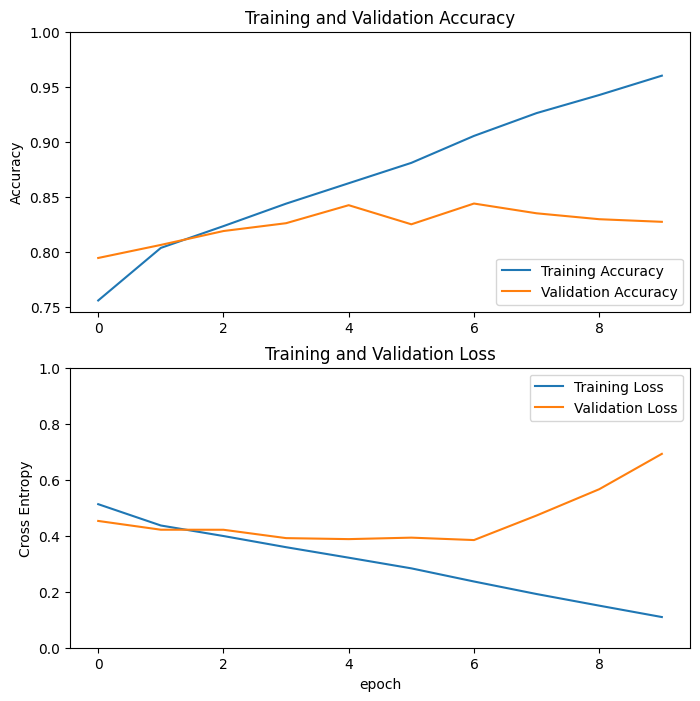

In [ ]:
preview_learning_curve()

Observations:

Overfitting: The training accuracy surpasses validation accuracy significantly.

Fluctuating Validation Accuracy: Indicates variability, possibly due to insufficient data regularization.

Validation Loss Increasing: Suggests the model may struggle to generalize.

Addressing overfitting:

Data Augmentation: Increase the range and variety of transformations to generate diverse training data.

Regularization:
Add Dropout Layers: Increase dropout in dense layers.
Add L2 Regularization to convolutional and dense layers.

Data Augmentation

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that at training time, our model will never see the exact same picture twice.

Let's create a new training data generator and apply several random transformations:

In [ ]:
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.2),
    ]
)

Adding Dropout layers

In [ ]:
inputs = layers.Input(shape=IMG_SIZE +(3,))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)
# Add dropout layer
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

In [ ]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 96, 96, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,203,489 (4.59 MB)

 Trainable params: 1,203,489 (4.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 - 197s - 197ms/step - accuracy: 0.7193 - loss: 0.5601 - val_accuracy: 0.6800 - val_loss: 0.6433
Epoch 2/10
1000/1000 - 195s - 195ms/step - accuracy: 0.7718 - loss: 0.4897 - val_accuracy: 0.7974 - val_loss: 0.4469
Epoch 3/10
1000/1000 - 197s - 197ms/step - accuracy: 0.7907 - loss: 0.4556 - val_accuracy: 0.7665 - val_loss: 0.4928
Epoch 4/10
1000/1000 - 199s - 199ms/step - accuracy: 0.8062 - loss: 0.4288 - val_accuracy: 0.7766 - val_loss: 0.5227
Epoch 5/10
1000/1000 - 196s - 196ms/step - accuracy: 0.8181 - loss: 0.4063 - val_accuracy: 0.8275 - val_loss: 0.3967
Epoch 6/10
1000/1000 - 195s - 195ms/step - accuracy: 0.8252 - loss: 0.3914 - val_accuracy: 0.7782 - val_loss: 0.5122
Epoch 7/10
1000/1000 - 194s - 194ms/step - accuracy: 0.8310 - loss: 0.3832 - val_accuracy: 0.7986 - val_loss: 0.4395
Epoch 8/10
1000/1000 - 191s - 191ms/step - accuracy: 0.8350 - loss: 0.3741 - val_accuracy: 0.8198 - val_loss: 0.4220
Epoch 9/10
1000/1000 - 193s - 193ms/step - accuracy: 0.8395 - lo

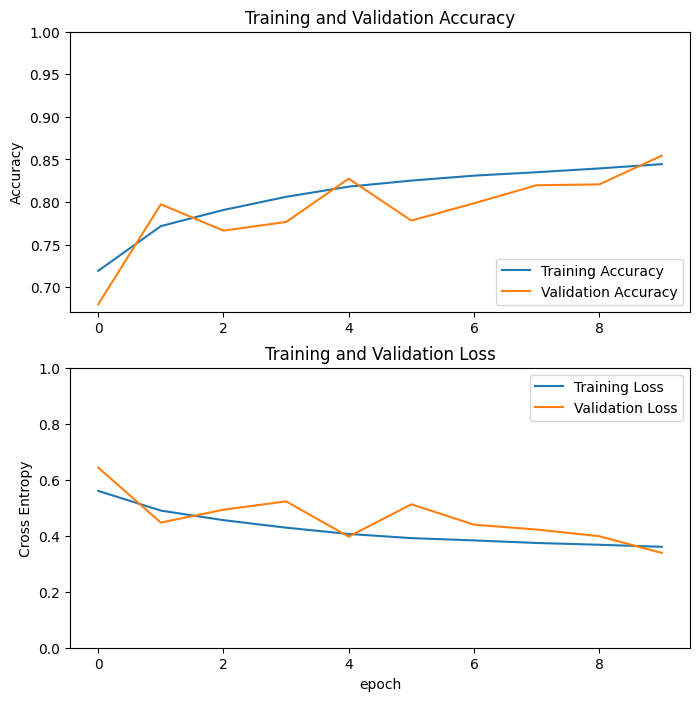

In [ ]:
# Compile model -> fit model -> preview learning curve
compile_model()
history = fit_model()
preview_learning_curve()

We can see below improvements:

Both training and validation accuracies are mostly above 80%.

Both training and validation accuracies show consistency than before.

The gap in accuracy between training and validation becomes smaller, this also indicates overfitting reduced.

This is the baseline model we built empirically, its accuracy looks good but not great, let’s get a taste of what the state-of-the-art (SOTA) Convolutional Neural Network (ConvNet) are like.

EfficientNetV2 Model

EfficientNetV2 is a highly efficient and scalable deep learning architecture for image classification tasks. It is an improved version of EfficientNet, optimized for performance on GPUs and TPUs with faster training and better accuracy.

Let's instantiate a EfficientNetB0 model pre-loaded with weights trained on ImageNet first. By specifying the include_top=False argument, we load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SIZE + (3,))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Build base_model and feature extractor layers using the Keras Functional API

In [ ]:
from tensorflow.keras import layers,models
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

# Create the full model
inputs = layers.Input(shape=IMG_SIZE + (3,))
x = preprocess_input(inputs)
x = data_augmentation(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)

Let's take a look at the efficientnet model architecture:

In [ ]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 3, 3, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 4,171,645 (15.91 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

initial_epochs = 10
history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=val_generator,
                    verbose=2
)

Epoch 1/10
1000/1000 - 875s - 875ms/step - accuracy: 0.7964 - loss: 0.4364 - val_accuracy: 0.8429 - val_loss: 0.3481
Epoch 2/10
1000/1000 - 829s - 829ms/step - accuracy: 0.8705 - loss: 0.3092 - val_accuracy: 0.8294 - val_loss: 0.3788
Epoch 3/10
1000/1000 - 860s - 860ms/step - accuracy: 0.8900 - loss: 0.2705 - val_accuracy: 0.8504 - val_loss: 0.3446
Epoch 4/10
1000/1000 - 827s - 827ms/step - accuracy: 0.9023 - loss: 0.2435 - val_accuracy: 0.8478 - val_loss: 0.3558
Epoch 5/10
1000/1000 - 858s - 858ms/step - accuracy: 0.9082 - loss: 0.2280 - val_accuracy: 0.8961 - val_loss: 0.2601
Epoch 6/10
1000/1000 - 827s - 827ms/step - accuracy: 0.9158 - loss: 0.2097 - val_accuracy: 0.8839 - val_loss: 0.2907
Epoch 7/10
1000/1000 - 823s - 823ms/step - accuracy: 0.9246 - loss: 0.1950 - val_accuracy: 0.9069 - val_loss: 0.2386
Epoch 8/10
1000/1000 - 822s - 822ms/step - accuracy: 0.9255 - loss: 0.1904 - val_accuracy: 0.9054 - val_loss: 0.2323
Epoch 9/10
1000/1000 - 824s - 824ms/step - accuracy: 0.9315 - lo

Let's preview the learning curve:

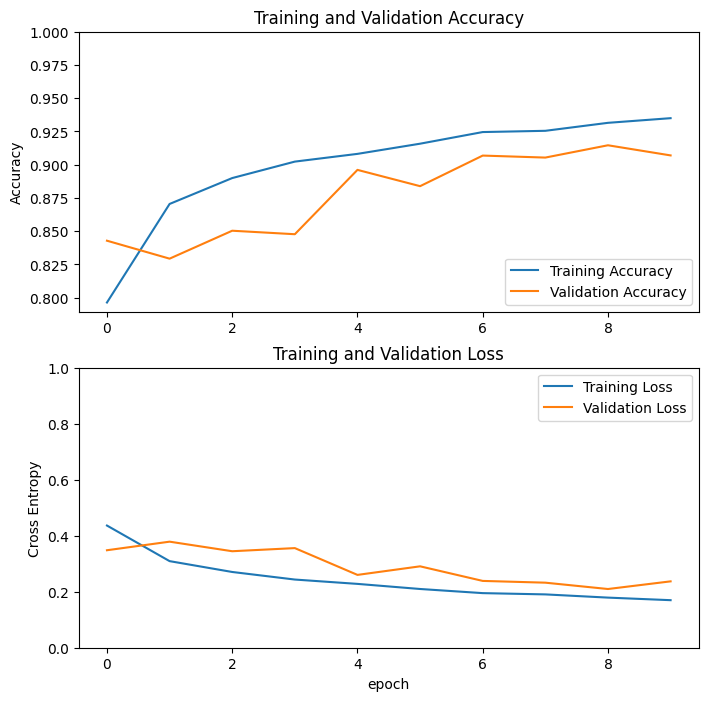

In [ ]:
preview_learning_curve()

Much better! The EfficientNetB0 model give significant higher training & validation accuracies and smaller loss values. We will use this model to make prediction.

Submission

Let's use the final_model to make prediction:

In [ ]:
test_path = '/kaggle/input/histopathologic-cancer-detection/test'

df_test = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
df_test['filename'] = df_test.id + '.tif'

test_datagen = ImageDataGenerator(preprocessing_function=tiff_to_rgb)
test_generator = test_datagen.flow_from_dataframe(
    dataframe = df_test,
    directory = test_path,
    x_col = 'filename',
    batch_size = BATCH_SIZE,
    shuffle = False,
    class_mode = None,
    target_size = IMG_SIZE,
)

Found 57458 validated image filenames.


In [ ]:
predictions = model.predict(test_generator, verbose=1)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



1796/1796 ━━━━━━━━━━━━━━━━━━━━ 455s 252ms/step


Convert the predictions to the labels:

In [ ]:
label_pred = np.where(predictions > 0.5, 1, 0)
label_pred

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

Apply predictions to submission dataframe:

In [ ]:
submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
submission.label = label_pred
submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [ ]:
submission.to_csv('submission.csv', header = True, index = False)

CONCLUSION:

The project explored various ConvNet models for Histopathologic Cancer Detection, progressing from a baseline model to a state-of-the-art (SOTA) EfficientNetB0 model. Here are the key takeaways and results:

Baseline Model:

Initial ConvNet models achieved reasonable training and validation accuracies but showed evidence of overfitting, as seen from the divergence between training and validation loss.
Overfitting was mitigated using data augmentation and the inclusion of dropout layers, leading to improved model generalization.
EfficientNetB0 Transfer Learning:

EfficientNetB0, a pre-trained SOTA model, significantly improved validation accuracy, achieving an average of 85% on the validation dataset.
By leveraging transfer learning, the model benefited from pre-trained feature extraction capabilities, coupled with a custom classifier on top for binary classification.
The learning curves demonstrated reduced overfitting and smaller loss values, validating the efficacy of this approach.
Challenges:

While the results are promising, there was still fluctuation in accuracy on the validation dataset. This suggests potential noise or anomalies in the dataset that may hinder consistency.
Future Improvements:

Further improvements can be achieved through fine-tuning of the EfficientNetB0 model, allowing more layers to learn dataset-specific patterns.
Employing anomaly detection techniques to clean up the dataset could reduce variability and improve overall performance.
Exploring hyperparameter optimization, including tuning dropout rates, learning rates, and augmentation strategies, could yield even better results.
Summary
EfficientNetB0 provided significant improvement over the baseline models, demonstrating the value of transfer learning for complex image classification tasks. The combination of modern architectures, data augmentation, and overfitting mitigation techniques proved highly effective. With additional fine-tuning and dataset refinement, the model's performance can be further enhanced, making it a strong candidate for real-world histopathologic cancer detection tasks.